### ***LOADING THE DATASET FROM KAGGLE ***

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ham1000-segmentation-and-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1370616%2F2275763%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240425%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240425T143751Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da03e7b8cc2f64c28e7f329a82bbf14f66f697ed3554513fb3c9e32497da24e67d6e47f5a0ed6a00405998c6afe52df4c017031bdd1918a08c23351476606709c375081274548a9b4b55679f5a2d560301a177e56997dfc68ab143df41d98b5c393cbf20c83df20f3899612954e0f3ea0c47264663ff1ba89fc2eba113dd0da47c60f900b6c33d7ed198fea6db88c4864a9b79ea7f12d22bfe6460d3a9e4ad3fc3b632234138b7f0d06c2d3a0fb990d26d8876194eb87a57cd1a5cb45add38626365902430e4dae112c30ed8e7bf98b833dfcabbbff40f3c8641754036880eaee4d530404f624595110ff1b68b9a25707acb05f217855e8bb43823464c1f7d753'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2781385274 bytes downloaded
Downloaded and uncompressed: ham1000-segmentation-and-classification
Data source import complete.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [3]:
pip install tensorflow

### IMPORTING  LIBRARIES

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D , MaxPooling2D , BatchNormalization , Conv2DTranspose , UpSampling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

#### LOADING THE DATASET AND SPLI THE DATASET FOR TRAIN TEST SPLIT

In [5]:
IMG_SIZE = 256
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMG_DIR = '/kaggle/input/ham1000-segmentation-and-classification/images'
MASK_DIR = '/kaggle/input/ham1000-segmentation-and-classification/masks'

In [6]:
def img_mask_path(img_dir , mask_dir) :
    image_path = sorted(gb.glob(os.path.join(img_dir , '*.jpg')))
    masks_path = sorted(gb.glob(os.path.join(mask_dir , '*.png')))
    image_path = np.array(image_path)
    masks_path = np.array(masks_path)

    return image_path , masks_path

In [7]:
imgs_path , masks_path = img_mask_path(IMG_DIR , MASK_DIR)

In [8]:
x_train , x_test , y_train , y_test = train_test_split(imgs_path , masks_path , train_size = 0.85,)

In [9]:
len(x_train) , len(x_test)

(8512, 1503)

### METHOD TO CONVERT THE IMAGE PATH TO IMAGE

In [10]:
def path_to_img(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.
    return image, mask

#### CREATING TRAINING AND TESTING DATASET OBJECT

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_set = tf.data.Dataset.from_tensor_slices((x_train , y_train))
train_set = train_set.map(path_to_img , num_parallel_calls=AUTOTUNE)
train_set = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)
test_set = tf.data.Dataset.from_tensor_slices((x_test , y_test))
test_set = test_set.map(path_to_img , num_parallel_calls=AUTOTUNE)
test_set = test_set.batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

In [ ]:
print(f"the size of the train dataloader {len(train_set)} batches of {BATCH_SIZE}")

the size of the train dataloader 266 batches of 32


In [ ]:
print(f"the size of the test dataloader {len(test_set)} batches of {BATCH_SIZE}")

the size of the test dataloader 47 batches of 32


In [ ]:
img_sample , mask_sample = next(iter(train_set))
img_sample.shape , mask_sample.shape

(TensorShape([32, 256, 256, 3]), TensorShape([32, 256, 256, 1]))



#### VISUALIZING THE DATASET IMAGE



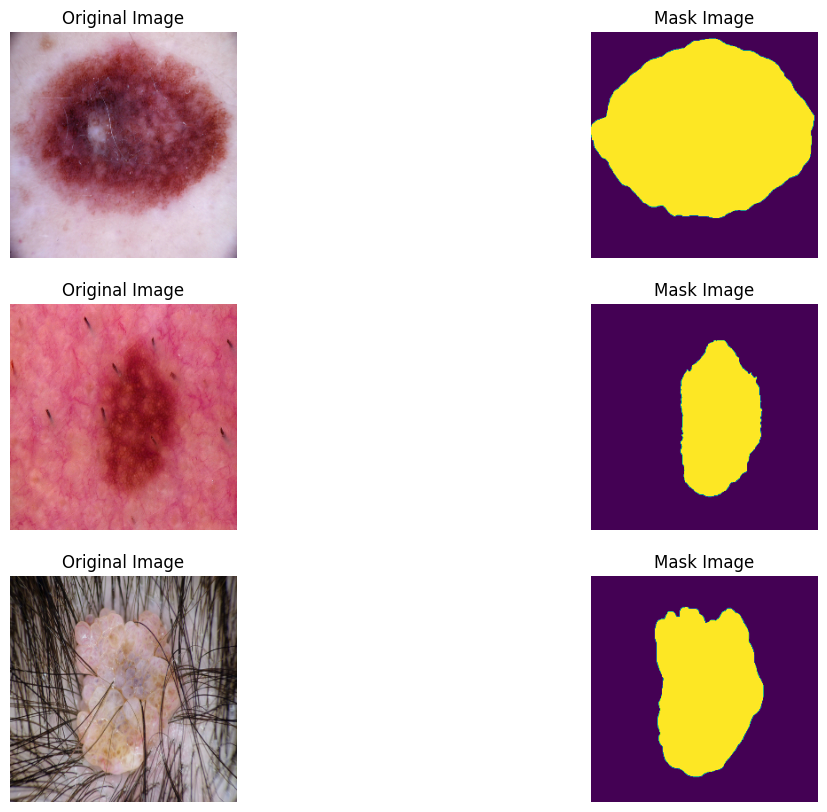

In [ ]:
fig , axis = plt.subplots(3 , 2 , figsize = (15,10))
for i in range(3):
    img1 = img_sample[i].numpy()
    axis[i, 0].imshow(img1)
    axis[i, 0].set(title = f"Original Image")
    axis[i, 0].axis('off')
    img2 = mask_sample[i].numpy()
    axis[i, 1].imshow(img2)
    axis[i, 1].set(title = f"Mask Image")
    axis[i, 1].axis('off')
plt.subplots_adjust(wspace=0.0)

#### BUILDING  UNET MODEL

In [ ]:
def UNET() :
    inputs = keras.Input(shape = (IMG_SIZE , IMG_SIZE , 3))

    x = Conv2D(32, 3, strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    skip_connections = []

    for filters in [64, 128, 256 , 512]:
        x = Conv2D(filters , 3 , strides = 1 , padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = Conv2D(filters , 3 , strides = 1 , padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        skip_connections.append(x)
        x = MaxPooling2D(2, strides=2, padding="same")(x)

    x = Conv2D(1024 , 3 , strides = 1 , padding = 'same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = Conv2D(1024 , 3 , strides = 1 , padding = 'same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    for filters in [512, 256 , 128 , 64] :
        x = Conv2DTranspose(filters , 2 , strides = 2 , padding = "same")(x)
        skip_connection = skip_connections.pop()
        x = layers.add([x , skip_connection])

        x = Conv2D(filters , 3 , strides = 1 , padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = Conv2D(filters , 3 , strides = 1 , padding = 'same')(x)
        x = BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    outputs = Conv2D(1 , 1 , strides = 1 , activation = "sigmoid")(x)


    model = Model(inputs , outputs)

    return model

In [ ]:
model = UNET()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

# Train our model

In [ ]:
model.compile(Adam(0.0002) , BinaryCrossentropy(), metrics=['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [ ]:
with tf.device("/GPU:0") :
    history = model.fit(
        train_set ,
        epochs = 2 ,
        batch_size = BATCH_SIZE ,
        validation_data = test_set ,
        workers = 8 ,
        use_multiprocessing = True
    )

Epoch 1/2
266/266 [==============================] - 492s 2s/step - loss: 0.2176 - accuracy: 0.9170 - precision: 0.8743 - recall: 0.8165 - val_loss: 0.3791 - val_accuracy: 0.8696 - val_precision: 0.8739 - val_recall: 0.5948
Epoch 2/2
266/266 [==============================] - 418s 2s/step - loss: 0.1426 - accuracy: 0.9444 - precision: 0.9219 - recall: 0.8758 - val_loss: 0.1432 - val_accuracy: 0.9444 - val_precision: 0.9147 - val_recall: 0.8790


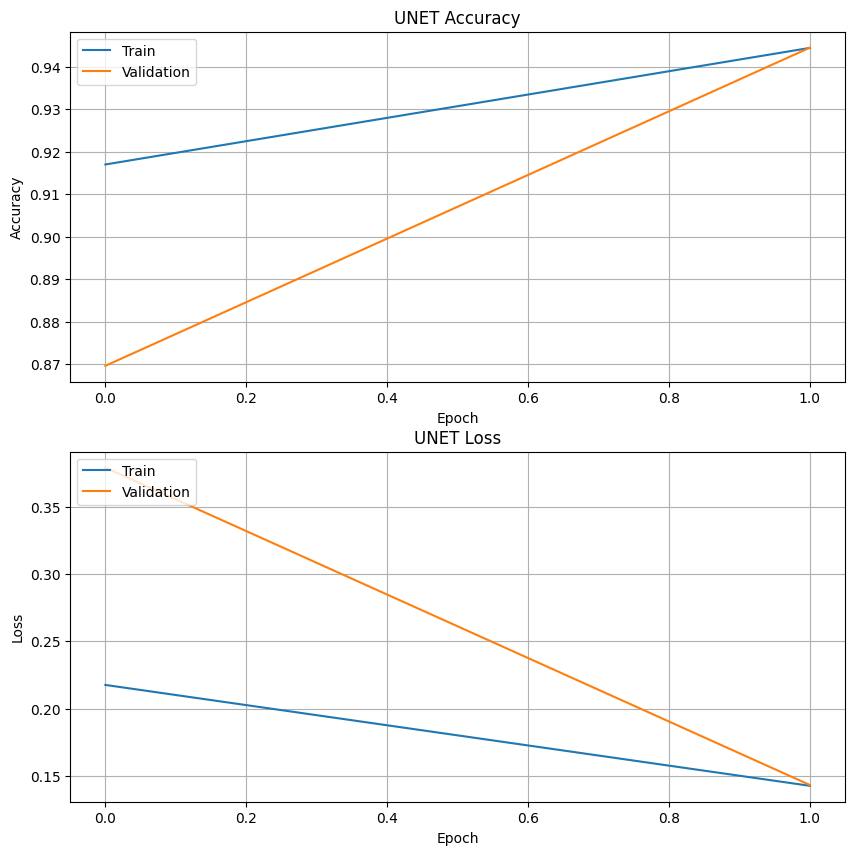

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Plot Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('UNET Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('UNET Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
train_f1_score = (2 * history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])
test_f1score = (2 * history.history['val_precision'][-1] * history.history['val_recall'][-1]) / (history.history['val_precision'][-1] + history.history['val_recall'][-1])

In [ ]:
print(f"The training loss is : {history.history['loss'][-1]:0.2f}\n")
print(f"The training accuracy is : {(history.history['accuracy'][-1]*100):0.2f}%\n")
print(f"The training precision is : {history.history['precision'][-1]:0.2f}\n")
print(f"The training recall is : {history.history['recall'][-1]:0.2f}\n")
print(f"The F1 score of the training set is : {train_f1_score:0.4f}\n")

The training loss is : 0.14

The training accuracy is : 94.44%

The training precision is : 0.92

The training recall is : 0.88

The F1 score of the training set is : 0.8983



In [ ]:
print(f"The testing loss is : {history.history['val_loss'][-1]:0.2f}\n")
print(f"The testing accuracy is : {(history.history['val_accuracy'][-1]*100):0.2f}%\n")
print(f"The testing precision is : {history.history['val_precision'][-1]:0.2f}\n")
print(f"The testing recall is : {history.history['val_recall'][-1]:0.2f}\n")
print(f"The F1 score of the testing set is : {test_f1score:0.4f}\n")

The testing loss is : 0.14

The testing accuracy is : 94.44%

The testing precision is : 0.91

The testing recall is : 0.88

The F1 score of the testing set is : 0.8965



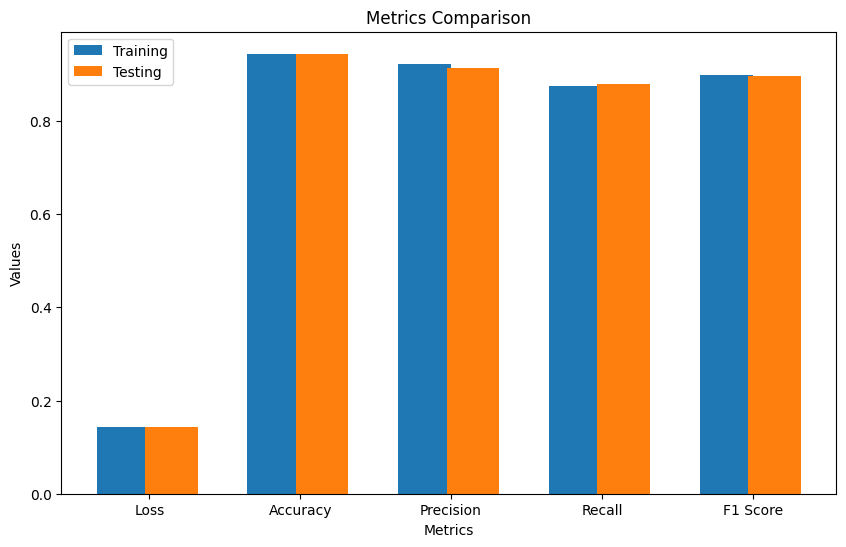

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
metrics= ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
training_metrics = [history.history['loss'][-1],
                    history.history['accuracy'][-1],
                    history.history['precision'][-1],
                    history.history['recall'][-1],
                    train_f1_score]
testing_metrics = [history.history['val_loss'][-1],
                   history.history['val_accuracy'][-1],
                   history.history['val_precision'][-1],
                   history.history['val_recall'][-1],
                   test_f1score]
plt.figure(figsize=(10, 6))
index = np.arange(len(metrics))
plt.bar(index, training_metrics, 0.35, label='Training')
plt.bar(index + 0.32, testing_metrics,0.35, label='Testing')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Comparison')
plt.xticks(index + 0.35 / 2, metrics)
plt.legend()
plt.show()


# Make predictions

In [ ]:
x_testsample , y_testsample = next(iter(test_set))

In [ ]:
y_pred = loaded_model.predict(x_testsample)

1/1 [==============================] - 0s 430ms/step


In [ ]:
def draw(test_images , test_masks , y_preds):

    plt.figure(figsize = (20, 10))
    index = 0
    n = np.random.randint(y_preds.shape[0])
    for i in range(18):
        plt.subplot(3, 6, (i + 1))
        if index == 0:
            plt.imshow(test_images[n])
            plt.imshow(test_images[n])
            plt.title('Original Image')
            index = 1
            plt.axis('off')
        elif index == 1:
            plt.imshow(test_masks[n])
            plt.imshow(test_masks[n], alpha = 0.2, cmap = 'viridis')
            plt.title('Original Mask')
            index = 2
            plt.axis('off')
        elif index == 2 :
            plt.imshow(test_masks[n])
            plt.imshow(y_preds[n], alpha = 0.2, cmap = 'viridis')
            plt.title('Predict Mask')
            index = 0
            n = np.random.randint(y_preds.shape[0])
            plt.axis('off')


    plt.legend()

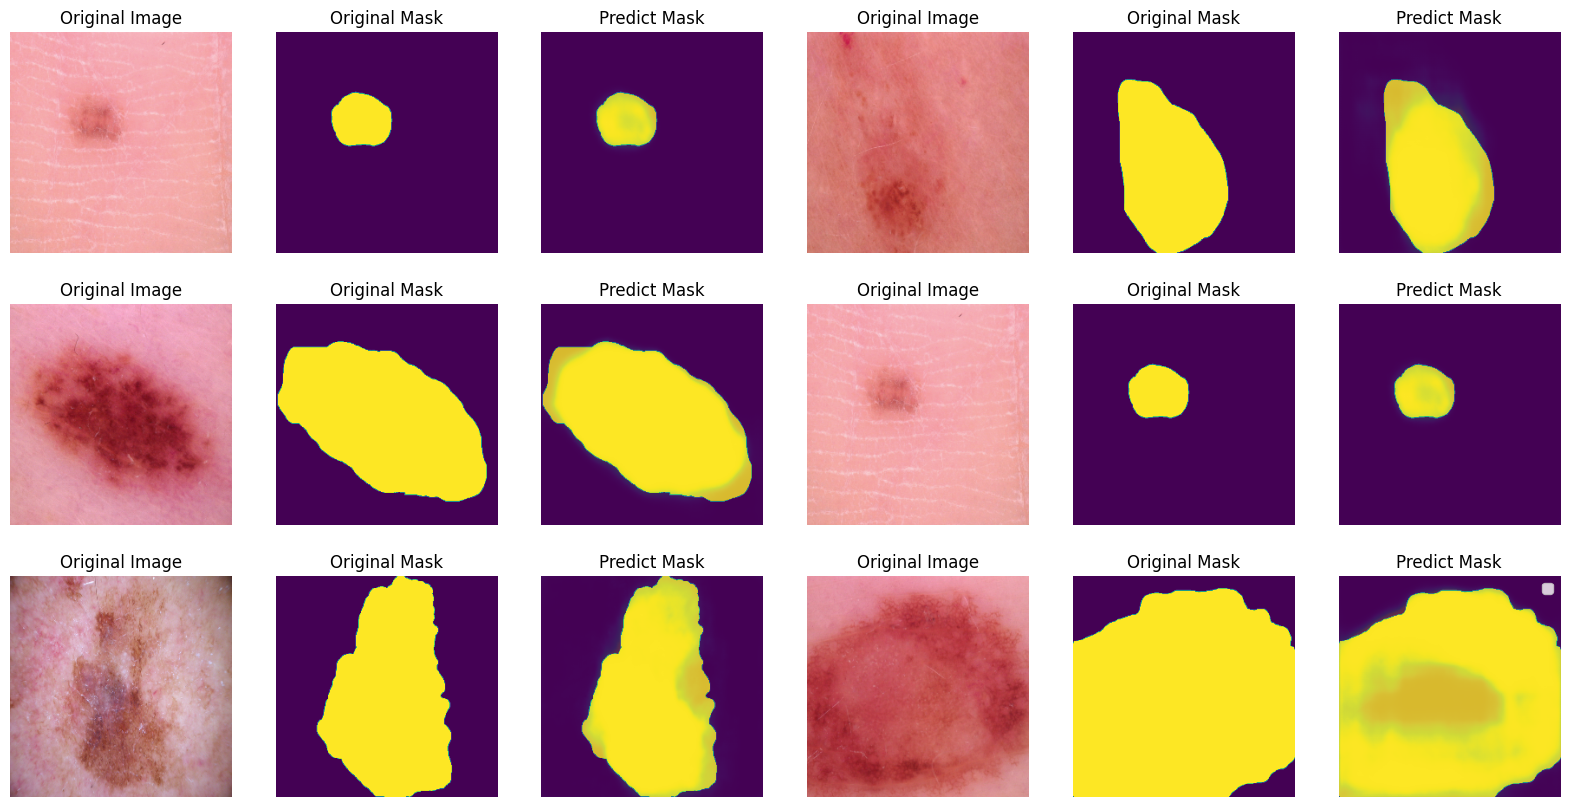

In [ ]:
draw(x_testsample, y_testsample , y_pred)

# Save our model

In [ ]:
model.save("/content/drive/MyDrive/skin_cancer_segmentation.h5")

### LOADING THE UNET MODEL

In [13]:
import tensorflow as tf
import cv2
import numpy as np
# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Skin cancer Segmentation.h5')

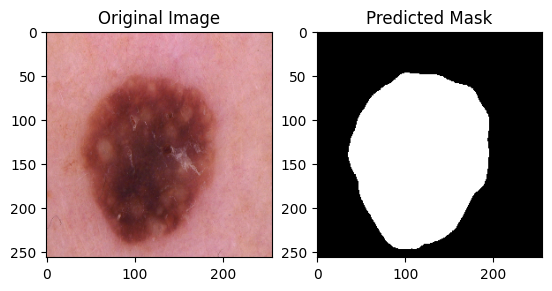

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x_testsample[1])
plt.title('Original Image')

# Display the predicted mask
plt.subplot(1, 2, 2)
plt.imshow(y_testsample[1]>0.5, cmap='gray')
plt.title('Predicted Mask')

plt.show()


In [ ]:
x_testsample[0].shape

TensorShape([256, 256, 3])

ADPATIVE MEDIAN FILTER FOR DENOISING

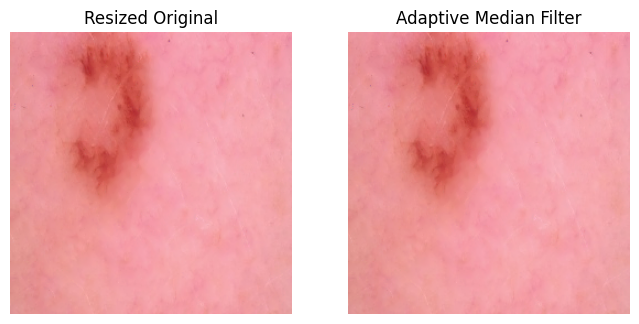

In [ ]:
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def resize_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path)
    img_resized = img.resize(target_size, Image.Resampling.BOX)
    img_array = np.array(img_resized)
    return img_array

def adaptive_median_filter(channel, max_size):
    height, width = channel.shape
    filtered_channel = np.zeros_like(channel)
    for i in range(height):
        for j in range(width):
            filtered_channel[i, j] = adaptive_median_value(channel, i, j, max_size)

    return filtered_channel

def adaptive_median_value(channel, i, j, max_size):
    height, width = channel.shape
    window_size = 3
    while window_size <= max_size:
        half_size = window_size // 2
        window = channel[max(0, i - half_size):min(height, i + half_size + 1),
                         max(0, j - half_size):min(width, j + half_size + 1)]

        median = np.median(window)

        if window[0, 0] < median < window[-1, -1]:
            return median
        else:
            window_size += 2

    return channel[i, j]

def apply_and_display_adaptive_median_filter(image_path, max_filter_size):
    resized_img = resize_image(image_path, target_size=(256, 256))
    filtered_img = np.zeros_like(resized_img)
    for c in range(3):
        filtered_img[:, :, c] = adaptive_median_filter(resized_img[:, :, c], max_filter_size)
    fig1, axis = plt.subplots(1, 2, figsize=(8, 4))
    axis[0].imshow(resized_img)
    axis[0].set_title('Resized Original')
    axis[0].axis('off')


    axis[1].imshow(filtered_img)
    axis[1].set_title('Adaptive Median Filter')
    axis[1].axis('off')

    plt.show()

image_path = '/content/preprocessed_ISIC_0024346.png'
max_filter_size = 1
apply_and_display_adaptive_median_filter(image_path, max_filter_size)


In [ ]:
def apply_and_display_adaptive_median_filter(image_path, max_filter_size):
    resized_img = resize_image(image_path, target_size=(256, 256))
    filtered_img = np.zeros_like(resized_img)
    for c in range(3):
        filtered_img[:, :, c] = adaptive_median_filter(resized_img[:, :, c], max_filter_size)
    # fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    return filtered_img
    # axes[0].imshow(resized_img)
    # axes[0].set_title('Resized Original')
    # axes[0].axis('off')


    # axes[1].imshow(filtered_img)
    # axes[1].set_title('Adaptive Median Filter')
    # axes[1].axis('off')

    # plt.show()

FEATURE EXTRACTION USING PSO

In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=f9e5a9667c6903e394cd21d8e912de04afac7632947ed69682bd63dc38e6c456
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


Stopping search: maximum iterations reached --> 100


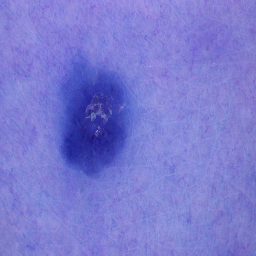

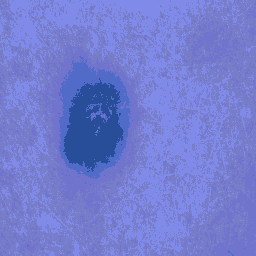

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from pyswarm import pso
from google.colab.patches import cv2_imshow

image = cv2.imread("/content/ISIC_0024364.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))

pix = image.reshape(-1, 3)
num_centroids = 5
num_particles = num_centroids * 3
lower_bound = np.zeros(3 * num_centroids)
upper_bound = np.ones(3 * num_centroids) * 255

def obj_function(pos):
    centroids = pos.reshape(-1, 3)
    labels = KMeans(n_clusters=len(centroids), init=centroids, n_init=1).fit_predict(pix)
    mse = np.mean((pix- centroids[labels]) ** 2)
    return mse

result, _ = pso(objective_function, lower_bound, upper_bound, swarmsize=num_particles)
centroids = result.reshape(-1, 3)
labels = KMeans(n_clusters=len(centroids), init=centroids, n_init=1).fit_predict(pixels)
segmented_image = centroids[labels].reshape(image.shape)

cv2_imshow(image)
cv2_imshow(segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
pip install pyswarm


  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=96fd77ba294da312ec88a9cfef7a70bd6cc77169bd4eda4f894c0437e1c2c935
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import cv2
img = segmented_image
 # Normalize pixel values to [0, 1]
img = cv2.resize(img, (256, 256))
img = img / 255.0  # Normalize pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Add batch dimension
import tensorflow as tf
import cv2
import numpy as np

predictions = loaded_model.predict(img)
prediction=(predictions>0.5)
prediction.shape

1/1 [==============================] - 0s 20ms/step


(1, 256, 256, 1)

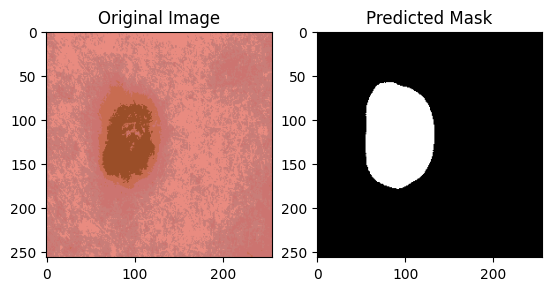

In [ ]:
import matplotlib.pyplot as plt

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(img[0])  # Assuming img is of shape (1, height, width, channels)
plt.title('Original Image')

# Display the predicted mask (you might need additional post-processing)
plt.subplot(1, 2, 2)
plt.imshow(prediction[0, :, :, 0], cmap='gray')  # Assuming predictions is of shape (1, height, width, 1)
plt.title('Predicted Mask')

plt.show()

In [ ]:
import cv2
img = cv2.imread("/content/ISIC_0024364.jpg")
 # Normalize pixel values to [0, 1]
img = cv2.resize(img, (256, 256))
img = img / 255.0  # Normalize pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Add batch dimension
import tensorflow as tf
import cv2
import numpy as np

predictions = loaded_model.predict(img)
prediction=(predictions>0.5)
prediction.shape

1/1 [==============================] - 0s 54ms/step


(1, 256, 256, 1)

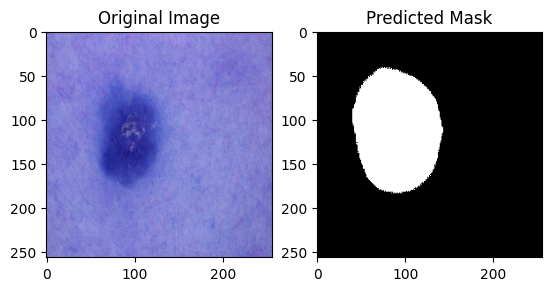

In [ ]:
import matplotlib.pyplot as plt

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(img[0])  # Assuming img is of shape (1, height, width, channels)
plt.title('Original Image')

# Display the predicted mask (you might need additional post-processing)
plt.subplot(1, 2, 2)
plt.imshow(prediction[0, :, :, 0], cmap='gray')  # Assuming predictions is of shape (1, height, width, 1)
plt.title('Predicted Mask')

plt.show()

In [ ]:
# prompt: give the code to store predicted  mask as 256,256,1 image as any format  but if the value is 1 it should be while and 0 means black

import numpy as np
import cv2

# Convert the prediction to a binary mask
prediction = np.where(prediction > 0.5, 1, 0)

# Resize the mask to 256x256
prediction = cv2.resize(prediction[0], (256, 256))

# Save the mask as a PNG image
cv2.imwrite('mask.png', prediction * 255)


True

# Deep CNN IMAGE CLASSIFICATION


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [15]:
csv_path = '/content/drive/MyDrive/GroundTruth.csv'
df = pd.read_csv(csv_path)

In [16]:
df.shape

(10015, 8)

In [17]:
MEL=df['MEL']
NV=df['NV']
BCC=df['BCC']
AKIEC=df['AKIEC']
BKL=df['BKL']
DF=df['DF']
VASC=df['VASC']

In [18]:
count_mel=df['MEL'].value_counts()[1]
count_nv=df['NV'].value_counts()[1]
count_bcc=df['BCC'].value_counts()[1]
count_akiec=df['AKIEC'].value_counts()[1]
count_bkl=df['BKL'].value_counts()[1]
count_df=df['DF'].value_counts()[1]
count_vasc=df['VASC'].value_counts()[1]


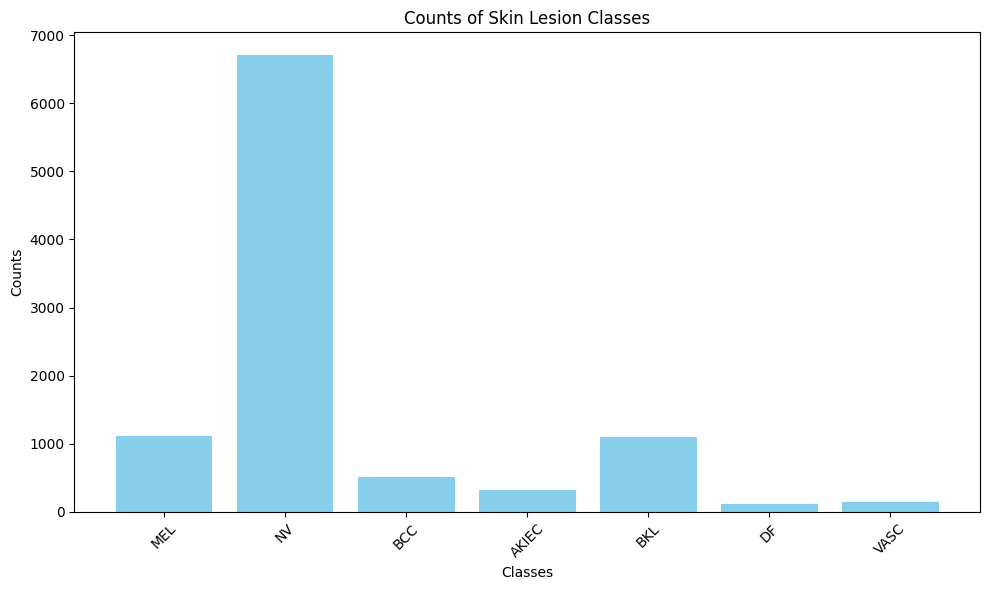

In [19]:
import matplotlib.pyplot as plt

# Counts of each class
counts = [count_mel, count_nv, count_bcc, count_akiec, count_bkl, count_df, count_vasc]

# Class labels
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Counts of Skin Lesion Classes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [20]:
image_path=df["image"]
labels= df.drop(['image'], axis=1)

In [21]:
image_path.shape

(10015,)

In [22]:
labels.shape

(10015, 7)

In [23]:
y_one_hot=labels.values

In [24]:
y_one_hot.shape

(10015, 7)

In [25]:
y_one_hot[0]

array([0., 1., 0., 0., 0., 0., 0.])

In [26]:
ls = []
# Assuming masks_path and image_path are lists or iterables of the same length
for (mask_path, image_path1) in zip(masks_path, image_path):
    if image_path1 in mask_path:
      ls.append(image_path1)


In [27]:

X = np.array(ls)


In [28]:
imgs_path.shape

(10015,)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(imgs_path , y_one_hot, test_size=0.3, random_state=42)


In [31]:
# prompt: code to display the x_train,y_train.shape split shape

print(f"The training set has {len(X_train)} images and {len(y_train)} labels")
print(f"The testing set has {len(X_test)} images and {len(y_test)} labels")


The training set has 7010 images and 7010 labels
The testing set has 3005 images and 3005 labels


In [32]:
X_train.shape,y_train.shape

((7010,), (7010, 7))

In [33]:
# # prompt: give a mapfn code that take image_path as argument and load the image and predict the mask from load_model.predict and return the predicted mask

# def map_fn1(image_path):
#   img = tf.io.read_file(image_path)
#   img = tf.image.decode_jpeg(img, channels=3)
#   img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
#   img = tf.cast(img, tf.float32) / 255.
#   mask = loaded_model.predict(np.expand_dims(img, axis=0))
#   mask = np.where(mask > 0.5, 1, 0)
#   prediction1 = np.squeeze(mask)
#   prediction2 = np.expand_dims(prediction1, axis=-1)
#   img_array = np.repeat(prediction2, 3, axis=2)
#   return img_array
def map_fn1(image_path):
  img = tf.io.read_file(image_path)
  #filtered_image= apply_and_display_adaptive_median_filter(image_path, 1)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = img / 255.
  mask = loaded_model.predict(np.expand_dims(img, axis=0))
  mask = np.where(mask > 0.5, 1, 0)
  prediction1 = np.squeeze(mask)
  prediction2 = np.expand_dims(prediction1, axis=-1)
  img_array = np.repeat(prediction2, 3, axis=2)
  return img_array

In [34]:
img=map_fn1(X_train[0])
img.shape
y_train[0].shape

1/1 [==============================] - 5s 5s/step


(7,)

In [ ]:
# prompt: code to display the img
img[100]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0,

In [ ]:
img.shape

(256, 256, 3)

In [35]:
image_height = 256
image_width = 256
num_channels = 3

In [36]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='sigmoid')  # Output layer with 7 neurons corresponding to 7 classes
])

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
num_classes = 7
epochs = 5

# Define variables for progress tracking
iteration = 0

# Training loop
for epoch in range(epochs):
    for batch_index, (image_filename, label) in enumerate(zip(X_train, y_train)):
        # Load and preprocess image
        image = map_fn1(image_filename)
        label = label.reshape((1, num_classes))
        iteration+=1
        # Train the model on batch
        loss, accuracy = model.train_on_batch(np.expand_dims(image, axis=0), label)
        # Show progress every 100 iterations
        if iteration % 300 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Iteration {iteration}, Loss: {loss}, Accuracy: {accuracy}')
            # Append loss and accuracy to history

    # Print loss and accuracy at the end of each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}, Accuracy: {accuracy}')


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step
Epoch 5/5, Iteration 30300, Loss: 0.019097622483968735, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Epoch 5/5, Iteration 30600, Loss: 0.0004609952447935939, Accuracy: 1.0
1/1 [==============================] - 0s 20ms/step
Epoch 5/5, Iteration 30900, Loss: 0.00013207517622504383, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Epoch 5/5, Iteration 31200, Loss: 2.3841830625315197e-06, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Epoch 5/5, Iteration 31500, Loss: 0.0003023882454726845, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Epoch 5/5, Iteration 31800, Loss: 0.0006562701892107725, Accuracy: 1.0
1/1 [==============================] - 0s 20ms/step
Epoch 5/5, Iteration 32100, Loss: 2.3841855067985307e-07, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Epoch 5/5, Iteration 32400, Loss: 

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# prompt: code to print x_train ,y_train.shape

print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (8012,)
y_train shape: (8012, 7)


In [ ]:
model.save("/content/drive/MyDrive/deepcnnT7.h5")

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/deepcnnT7.h5')


In [ ]:
sample_input = map_fn1("/content/ISIC_0024315.jpg")

# Reshape the input to include the batch dimension
reshaped_input = np.expand_dims(sample_input, axis=0)

# Now, the shape of reshaped_input should be (1, 256, 256, 3)
model.predict(reshaped_input),y_train[19]

1/1 [==============================] - 0s 80ms/step


(array([[8.5271055e-01, 2.8165363e-05, 5.4403401e-08, 5.4228166e-10,
         1.7916081e-04, 2.3083636e-10, 1.3491630e-11]], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0.]))